In [1]:
import numpy as np
import pandas as pd
import random
import shap
from math import sqrt
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
#individuals
n = 2000
#loci
m = 100


#here every matrix entree has to be zero or one, with having a f_i probability to get selected
#frequency of alleles, random uniform distribution between 0 and 1, with m samples
f_M = np.random.uniform(0,1,m)

#initialize G matrix
# G = np.zeros((n, m));

# #will be used to flip a coin based on f_i
# #higher f_i frequency = higher chance of returning true
# def loci_frequency_flip(f_i):
#     return random.random() < f_i

# #use this if I wanted to populate entire G matrix
# #k are the colums(loci)
# for k in range (0, len(G[0])):
#     # j are the rows(individuals)
#     for j in range (0, len(G)):
#         #frequency of loci k we are currently on
#         if(loci_frequency_flip(f_M[k])):
#             G[j,k] = 1

G = np.random.binomial(n=2,p = f_M, size =  (n,m))

# If 0, independently standardize each feature, otherwise (if 1) standardize each sample, so choosing 0 
# to do column wise scaling
G = preprocessing.scale(G, axis=0)
# choose random SNP
loci =random.randint(0,m-1)

#select SNP
SNP = G[:,loci]

#preview of the data
print(SNP[0:30])

[-0.40375251 -0.40375251 -0.40375251  1.06177384 -0.40375251  1.06177384
  1.06177384 -0.40375251  1.06177384 -0.40375251 -0.40375251 -1.86927886
 -0.40375251  1.06177384 -0.40375251 -0.40375251 -1.86927886  1.06177384
 -0.40375251  1.06177384 -1.86927886 -0.40375251  1.06177384  1.06177384
 -0.40375251 -0.40375251  1.06177384  1.06177384 -0.40375251  1.06177384]


In [3]:

# mean and standard deviation
H=0
#assumes that we are making a Y_j for every individual in the SNP and 
#in each loop we choose a e_j for that person
def Simulate_Phenotype_PerPerson(SNP,var_e,var_g):
    
    #rows are the loci so each person has a row of different loci
    individuals = len(SNP)
    
    #where columns are the individuals
    mean = 0 
    
    #because we are given variance and python random.normal only accepts std, we need to convert variance to std
    sigma_e = sqrt(var_e)
    sigma_b = sqrt(var_g)
    
    #b_i = loci effect on phenotype
    b_i = np.random.normal(0, sigma_b)
    Y_n = np.zeros((individuals, 1));
    
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G_ij will be the jth individual from our SNP for the loci of choce
        G_ij  = SNP[k]
        Y_j = b_i*G_ij + e_j
        Y_n[k] = Y_j 
    H= var_g/(var_g+var_e)
    return Y_n,H


In [4]:
Y,H = Simulate_Phenotype_PerPerson(SNP,.1,.1)

In [5]:
#third function assumes that for each person j in M we make a phenotype Y_j
print('Phenotypes for loci '+str(loci)+' are '+str(Y[0:30]))

Phenotypes for loci 6 are [[-0.12190277]
 [ 0.20437407]
 [ 0.26951687]
 [-0.91319933]
 [ 0.08460235]
 [-0.43799014]
 [-0.35680692]
 [ 0.39646899]
 [-0.19403273]
 [ 0.40789442]
 [ 0.5828018 ]
 [ 0.239571  ]
 [ 0.38273276]
 [-0.36871268]
 [ 0.66040049]
 [ 0.1629097 ]
 [ 0.50213074]
 [-0.25925599]
 [-0.37603841]
 [-0.34598612]
 [ 0.91370744]
 [-0.10471556]
 [ 0.17180829]
 [-0.60586704]
 [ 0.53143551]
 [ 0.39601395]
 [-0.46143025]
 [-0.849856  ]
 [-0.03202492]
 [-0.54515951]]


In [6]:
G = np.append(G, Y, axis=1)

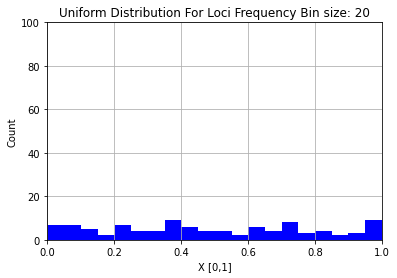

In [7]:
#use this to see distribution of f_i frequency
bin_size = 20
count, bins, ignored = plt.hist(f_M, 20, facecolor='blue') 

plt.xlabel('X [0,1]')
plt.ylabel('Count')
plt.title("Uniform Distribution For Loci Frequency Bin size: "+str(bin_size))
plt.axis([0, 1, 0, 100]) # x_start, x_end, y_start, y_end
plt.grid(True)

plt.show(block = False)

In [8]:
#starting machine learning classification
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.linear_model import LinearRegression

In [9]:
#split data into test and train
X = G[:,0:len(G[0])-2]

#last column is the appended Y vector we predicted
y = G[:,len(G[0])-1]

#split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [10]:
linReg = LinearRegression()  
x_train2 = np.abs(x_train)
y_train2 = np.abs(y_train)

In [12]:
#training the algorithm
linReg.fit(x_train2, y_train2) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
#regression model of SVM with RBF kernal
#svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)

In [13]:
# train the model
#svr_rbf.fit(x_train, y_train)

#test the model on test data
y_predict = linReg.predict(abs(x_test))

In [14]:
#Evaluate the regression model
import sklearn.metrics as sm
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_predict), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_predict), 2)) 
print("Root Mean squared error =", sqrt(round(sm.mean_squared_error(y_test, y_predict), 2)))
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_predict), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_predict), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_predict), 2))

Mean absolute error = 0.5
Mean squared error = 0.37
Root Mean squared error = 0.6082762530298219
Median absolute error = 0.46
Explain variance score = -0.07
R2 score = -0.76
